In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./graphs

%tensorflow_version 2.x

!apt-get update -y
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install x11-utils
!apt install xvfb

!dpkg --configure -a
!pip install tqdm
!pip install box2d  
#http://fnl.es/a-quick-reference-for-working-with-tensorflow.html

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:4 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Get:6 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Ign:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Get:12 https://developer.download.nvidia.com/compute/machine-lear

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import gym
from IPython import display as ipythondisplay
from IPython.display import clear_output
from pyvirtualdisplay import Display

import tensorflow.compat.v1 as tf
from collections import deque
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input , BatchNormalization, Concatenate, LayerNormalization, LSTM,Reshape
from tensorflow.keras.optimizers import Adam
import random
import tqdm
import pandas as pd

tf.disable_eager_execution()
from google.colab import drive
drive.mount('/content/drive')
import math
import time


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
tf.reset_default_graph()
epsilon = 0


In [ ]:
class Agent:
  def __init__(self, name, state_shape, n_actions, sess, isConvLSTM, nEnviroment, reuse=False):
    """A simple actor-critic agent"""
    self.n_actions = n_actions
    self.nEnviroment = nEnviroment
    self.state_shape = state_shape
    self.sess = sess
    self.isConvLSTM = isConvLSTM

    with tf.variable_scope(name, reuse=reuse):

      # Prepare neural network architecture
      inputs = Input(shape=state_shape)
      x = Dense(32, activation='relu', name ="inp1")(inputs)
      x = Dense(32, activation='relu', name ="inp2")(x)
      rnn_in = Reshape((1 ,x.shape[1]), input_shape=x.shape)(x)
      x = LSTM(64, return_sequences=False, name ="lstm_enc_1")(rnn_in)
    
      # two different output layers
      logits = Dense(self.n_actions, activation='linear', name ="logits")(x)
      state_value = Dense(1, activation='linear', name ="v")(x)
      self.network = Model(inputs=inputs, outputs=[logits, state_value])

      # prepare a graph for agent step
      self.state_t = tf.placeholder('float32', [None,] + list(self.state_shape))
      self.agent_outputs = self.symbolic_step(self.state_t)
      
  def symbolic_step(self, state_t):
    l,s = self.network(state_t)
    
    logits = l
    state_values = s[:,0]
    
    return logits, state_values
  
  def step(self, state_t):
      """Same as symbolic step except it operates on numpy arrays"""
      return self.sess.run(self.agent_outputs, {self.state_t: state_t})
  
  def sample_actions(self, agent_outputs,epsilon):
      """pick actions given numeric agent outputs (np arrays)"""
      if np.random.random() < epsilon:
        return np.random.randint(self.n_actions, size=self.nEnviroment)

      logits, state_values = agent_outputs
      policy = np.exp(logits) / np.sum(np.exp(logits), axis=-1, keepdims=True)
      return np.array([np.random.choice(len(p), p=p) for p in policy])


In [ ]:
class MountainA3C:
  def __init__(self, sess,env, lstm,gae):
    # These placeholders mean exactly the same as in "Let's try it out" section above
    self.sess =sess
    
    self.filepath = "/content/drive/My Drive/Colab Notebooks/RL/TF_mountain_multithread/data.txt"
    self.batch_size =10
    self.memory = deque(maxlen= self.batch_size)
    self.nEnviroment=10
    self.Training= 1000000#400000
    self.learning_rate= 0.0001
    self.entropy_factor = 0.01

    self.rewards_history = []
    self.entropy_history = []
    self.actor_history =[]
    self.critic_history =[]
    self.advantage_history = []
    self.target_history =[]
    self.v_history =[]
    self.actionList =[]

    self.reward_step =0

    self.writer = tf.summary.FileWriter('./graphs', sess.graph)

    self.is_gae = gae
    self.isConvLSTM = lstm 
    self.env = env
    self.obs_shape = self.env.observation_space.shape
    self.n_actions = self.env.action_space.n

    print("Observation shape:", self.obs_shape)
    print("Num actions:", self.n_actions)

    self.agent = Agent("agent", self.env.observation_space.shape, self.env.action_space.n, self.sess,self.isConvLSTM, self.nEnviroment)
    self.states_ph = tf.placeholder('float32', [None,] + list(self.obs_shape))    
    self.next_states_ph = tf.placeholder('float32', [None,] + list(self.obs_shape))
    self.actions_ph = tf.placeholder('int32', (None,))
    self.rewards_ph = tf.placeholder('float32', (None,))
    self.is_done_ph = tf.placeholder('float32', (None,))
    self.game_reward = tf.placeholder('float32', [None,])

    # logits[n_envs, n_actions] and state_values[n_envs, n_actions]
    self.logits, self.state_values = self.agent.symbolic_step(self.states_ph)
    self.next_logits, self.next_state_values = self.agent.symbolic_step(self.next_states_ph)

    # There is no next state if the episode is done!
    self.next_state_values = self.next_state_values * (1 - self.is_done_ph)

    # probabilities and log-probabilities for all actions
    self.probs = tf.nn.softmax(self.logits, axis=-1)            # [n_envs, n_actions]
    self.logprobs = tf.nn.log_softmax(self.logits, axis=-1)     # [n_envs, n_actions]

    # log-probabilities only for agent's chosen actions
    self.logp_actions = tf.reduce_sum(self.logprobs * tf.one_hot(self.actions_ph, self.n_actions), axis=-1) # [n_envs,]

    self.gamma = 0.99
    self.advantage = self.rewards_ph + self.gamma*self.next_state_values - self.state_values
    self.entropy = -tf.reduce_sum(self.probs * self.logprobs, 1, name="entropy")
    self.target_state_values = self.rewards_ph+self.gamma*self.next_state_values
    self.actor_loss = -tf.reduce_mean(self.logp_actions * tf.stop_gradient(self.advantage), axis=0) - self.entropy_factor * tf.reduce_mean(self.entropy, axis=0)
    self.critic_loss = tf.reduce_mean((self.state_values - tf.stop_gradient(self.target_state_values))**2, axis=0)
    self.train_step = tf.train.AdamOptimizer(self.learning_rate).minimize(self.actor_loss + self.critic_loss)

    self.summary_adv = tf.summary.scalar('advantage_', tf.reduce_mean(self.advantage, axis=-1))
    self.summary_ent = tf.summary.scalar('entropy_',tf.reduce_mean(self.entropy, axis=-1))
    self.summary_target = tf.summary.scalar('target_state_values_',tf.reduce_mean(self.target_state_values, axis=-1))
    self.summary_act_loss = tf.summary.scalar('actor_loss_', self.actor_loss)
    self.summary_crit_loss = tf.summary.scalar('critic_loss_', self.critic_loss)
    self.summary_batchreward = tf.summary.scalar('batchreward', tf.reduce_mean(self.rewards_ph, axis=-1))
    self.summary_v = tf.summary.scalar('state_values', tf.reduce_mean(self.state_values, axis=-1))
    self.summary_r = tf.summary.scalar('mean_reward', tf.reduce_mean(self.game_reward, axis=-1))

  def evaluate(self, n_games=1):
      """Plays an a game from start till done, returns per-game rewards """
      game_rewards = []
      for _ in range(n_games):
          state = self.env.reset()

          total_reward = 0
          while True:
              action = self.agent.sample_actions(self.agent.step([state]),0)[0]
              state, reward, done, info = self.env.step(action)
              #reward = mountainA3C.edit_reward([state],[reward])[0]
              total_reward += reward
              if done:
                  break

          game_rewards.append(total_reward)

      avr_reward =sess.run(self.summary_r, { self.game_reward: np.array(game_rewards).reshape(n_games,)})
                           
      self.writer.add_summary(avr_reward,self.reward_step)
      self.reward_step +=1

      return game_rewards


  def train(self,batch_states,batch_actions,batch_next_states,batch_rewards,batch_done,step):

    feed_dict = {
            self.states_ph: batch_states,
            self.actions_ph: batch_actions,
            self.next_states_ph: batch_next_states,
            self.rewards_ph: batch_rewards,
            self.is_done_ph: batch_done,
        }

    _, ent_t,act,crit,adv,targ,v,sum_adv,sum_ent,sum_target,sum_act_loss,sum_crit_loss,sum_batchreward,sum_v = sess.run([self.train_step, self.entropy,self.actor_loss ,self.critic_loss,self.advantage,
                                             self.target_state_values,self.state_values,
                                             self.summary_adv,self.summary_ent,self.summary_target,self.summary_act_loss,self.summary_crit_loss,
                                             self.summary_batchreward,self.summary_v], feed_dict)

    self.writer.add_summary(sum_adv, step)
    self.writer.add_summary(sum_ent, step)
    self.writer.add_summary(sum_target, step)
    self.writer.add_summary(sum_act_loss, step)
    self.writer.add_summary(sum_crit_loss, step)
    self.writer.add_summary(sum_batchreward, step)
    self.writer.add_summary(sum_v, step)

    self.entropy_history.append(np.mean(ent_t))
    self.actor_history.append(np.mean(act))
    self.critic_history.append(np.mean(crit))
    self.advantage_history.append(np.mean(adv))
    self.target_history.append(np.mean(targ))
    self.v_history.append(np.mean(v))
    
    for a in batch_actions:
      self.actionList.append(a)

  def edit_reward(self,s_,r):
    for i in range(len(r)):
      if s_[i][0] >= -0.2 and  s_[i][0] < 0.0:
        r[i]= -0.8 #0.3*0.1
      elif s_[i][0] >= 0.0 and  s_[i][0] < 0.2:
        r[i]= -0.6#0.5*0.1
      elif s_[i][0] >= 0.2 and  s_[i][0] < 0.4:
        r[i]= -0.4 # 0.7*0.1
      elif s_[i][0] >= 0.4:
        r[i]= -0.2#1 #-0.2*0.1
      else:
        r[i] = -1

    return r


  def ewma(self,x, span=100):
    return pd.DataFrame({'x':np.asarray(x)}).x.ewm(span=span).mean().values

  def plots(self):
    ipythondisplay.clear_output(wait=True)
    plt.figure(figsize=[35,13])
    plt.subplot(2,4,1)
    plt.plot(self.rewards_history, label='reward')
    plt.plot(self.ewma(np.array(self.rewards_history), span=10), marker='.', label='rewards ewma@10')
    plt.title("Session rewards"); plt.grid(); plt.legend()

    plt.subplot(2,4,2)
    plt.plot(self.actor_history, label='Actor Loss')
    plt.plot(self.ewma(np.array(self.actor_history), span=10), marker='.', label='Actor Loss ewma@10')
    plt.title("Policy Function"); plt.grid(); plt.legend()  

    plt.subplot(2,4,3)
    plt.plot(self.entropy_history, label='Entropy')
    plt.plot(self.ewma(np.array(self.entropy_history), span=10), marker='.', label='Entropy ewma@10')
    plt.title("Policy Function"); plt.grid(); plt.legend()      
    
    plt.subplot(2,4,4)
    plt.plot(self.target_history, label='Target ')
    plt.plot(self.v_history, label='V')
    plt.title("Target/V"); plt.grid(); plt.legend()

    plt.subplot(2,4,5)
    plt.plot(self.advantage_history, label='Advantage')
    plt.title("Advantage"); plt.grid(); plt.legend()  

    plt.subplot(2,4,6)
    plt.plot(self.critic_history, label='Critic Loss')
    plt.plot(self.ewma(np.array(self.critic_history), span=10), marker='.', label='Critic Loss ewma@10')
    plt.title("Value function"); plt.grid(); plt.legend()   

    plt.subplot(2,4,7)
    plt.plot(self.actionList, label='Actions')
    plt.title("Actions"); plt.grid(); plt.legend()  

    plt.show()
    


In [ ]:
class EnvBatch:
  def __init__(self, n_envs = 10):
    #Creates n_envs environments and babysits them for ya'
    self.envs = [gym.make("MountainCar-v0").env for _ in range(n_envs)]
    self.counter = [0 for _ in range(n_envs)]
    
  def reset(self):
    #Reset all games and return [n_envs, *obs_shape] observations 
    return np.array([env.reset() for env in self.envs])
  
  def step(self, actions):
    
    #Send a vector[batch_size] of actions into respective environments
    #:returns: observations[n_envs, *obs_shape], rewards[n_envs], done[n_envs,], info[n_envs]
    
    results = [env.step(a) for env, a in zip(self.envs, actions)]
    new_obs, rewards, done, infos = map(np.array, zip(*results))
    self.counter = [(self.counter[j]+1) for j in range(len(self.envs))]

    # reset environments automatically
    for i in range(len(self.envs)):
      if done[i] or self.counter[i] == 2000:
        new_obs[i] = self.envs[i].reset()
        self.counter[i] =0
    
    return new_obs, rewards, done, infos
    

'class EnvBatch:\n  def __init__(self, n_envs = 10):\n    self.envs = [gym.make("MountainCar-v0") for _ in range(n_envs)]\n    \n  def reset(self):\n    return np.array([env.reset() for env in self.envs])\n  \n  def step(self, actions):\n    results = [env.step(a) for env, a in zip(self.envs, actions)]\n    new_obs, rewards, done, infos = map(np.array, zip(*results))\n\n    # reset environments automatically\n    for i in range(len(self.envs)):\n      if done[i] :\n        new_obs[i] = self.envs[i].reset()\n    \n    return new_obs, rewards, done, infos'

In [ ]:
sess = tf.Session(graph= tf.get_default_graph())
RESET = 1
is_gae = False
isConvLSTM = True 


In [ ]:
display = Display(visible=0, size=(400, 300))
display.start()
env = gym.make("MountainCar-v0")
mountainA3C = MountainA3C(sess,env, isConvLSTM,is_gae)

Observation shape: (2,)
Num actions: 3


In [ ]:

if (RESET == 1):
  # ************ RESET everything **************************
  sess.run(tf.global_variables_initializer())
  saver = tf.train.Saver()
  f=open(mountainA3C.filepath, "w")
  f.write("")
  f.close()
  !rm -r /content/drive/My\ Drive/Colab\ Notebooks/RL/TF_mountain_multithread/graphs/*
else:
  # ************ LOAD everything **************************
  epsilon = 0.01 
  saver = tf.train.Saver()
  saver.restore(sess, tf.train.latest_checkpoint('/content/drive/My Drive/Colab Notebooks/RL/TF_mountain_multithread/'))
  !cp -r  /content/drive/My\ Drive/Colab\ Notebooks/RL/TF_mountain_multithread/graphs/ /content/
  f=open(mountainA3C.filepath,'r')
  for line in f:
    mountainA3C.rewards_history.append(float(line.split()[0]))
    mountainA3C.actor_history.append(float(line.split()[1]))
    mountainA3C.entropy_history.append(float(line.split()[2]))
    mountainA3C.target_history.append(float(line.split()[3]))
    mountainA3C.v_history.append(float(line.split()[4]))
    mountainA3C.advantage_history.append(float(line.split()[5]))
    mountainA3C.critic_history.append(float(line.split()[6]))
  f.close()
  mountainA3C.plots()

# Validate
rewards = mountainA3C.evaluate(n_games=3)
print(rewards)

env_batch = EnvBatch(10)
batch_states = env_batch.reset()
batch_actions = mountainA3C.agent.sample_actions(mountainA3C.agent.step(batch_states),0)
batch_next_states, batch_rewards, batch_done, _ = env_batch.step(batch_actions)

print("State shape:", batch_states.shape)
print("Actions:", batch_actions)
print("Rewards:", batch_rewards)
print("Done:", batch_done)

#Initialize
env_batch = EnvBatch(10)
batch_states = env_batch.reset()

rm: cannot remove '/content/drive/My Drive/Colab Notebooks/RL/TF_mountain_multithread/graphs/*': No such file or directory
[-200.0, -200.0, -200.0]
State shape: (10, 2)
Actions: [1 1 2 0 1 2 2 1 0 0]
Rewards: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
Done: [False False False False False False False False False False]


In [ ]:
  %tensorboard --logdir graphs
  time.sleep(15)

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
 60%|█████▉    | 599991/1000000 [1:24:10<52:01, 128.16it/s]

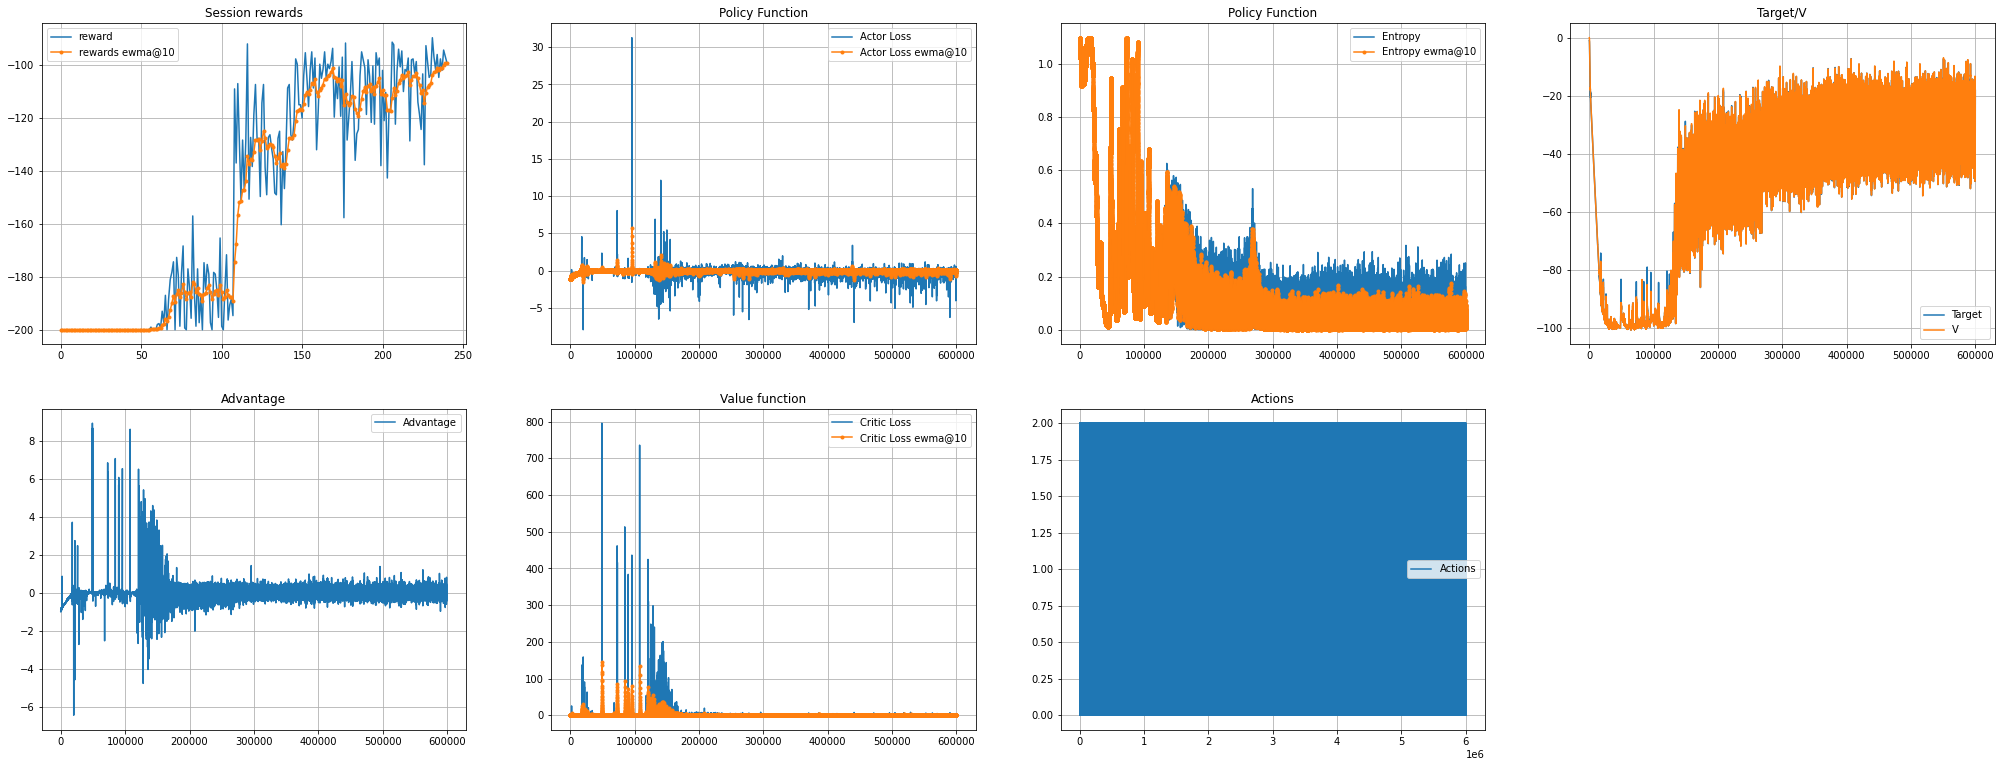

 61%|██████▏   | 612501/1000000 [1:26:03<54:26, 118.62it/s] 

Your agent reached the objetive


In [ ]:

#epsilon=0
with tqdm.trange(len(mountainA3C.entropy_history), mountainA3C.Training) as t:
  for i in t:
    agent_outputs = mountainA3C.agent.step(batch_states)
    batch_actions = mountainA3C.agent.sample_actions(agent_outputs,epsilon)
    batch_next_states, batch_rewards, batch_done, _ = env_batch.step(batch_actions)
    batch_rewards = mountainA3C.edit_reward(batch_next_states,batch_rewards)
    # Reward scaling. See above for explanation.
    mountainA3C.train(batch_states,batch_actions,batch_next_states,batch_rewards,batch_done,i)
    batch_states = batch_next_states

    if len(mountainA3C.rewards_history)> 100 :
      if np.mean(mountainA3C.rewards_history[-100:]) >= -107:
        print("Your agent reached the objetive")
        break

    if i % 500 == 0:
      if i % 2500 == 0:
        mountainA3C.rewards_history.append(np.mean(mountainA3C.evaluate(n_games=3)))

      if i % 50000 == 0:
        mountainA3C.plots()

      if epsilon > 0.01 :
        epsilon = epsilon*0.99
   

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


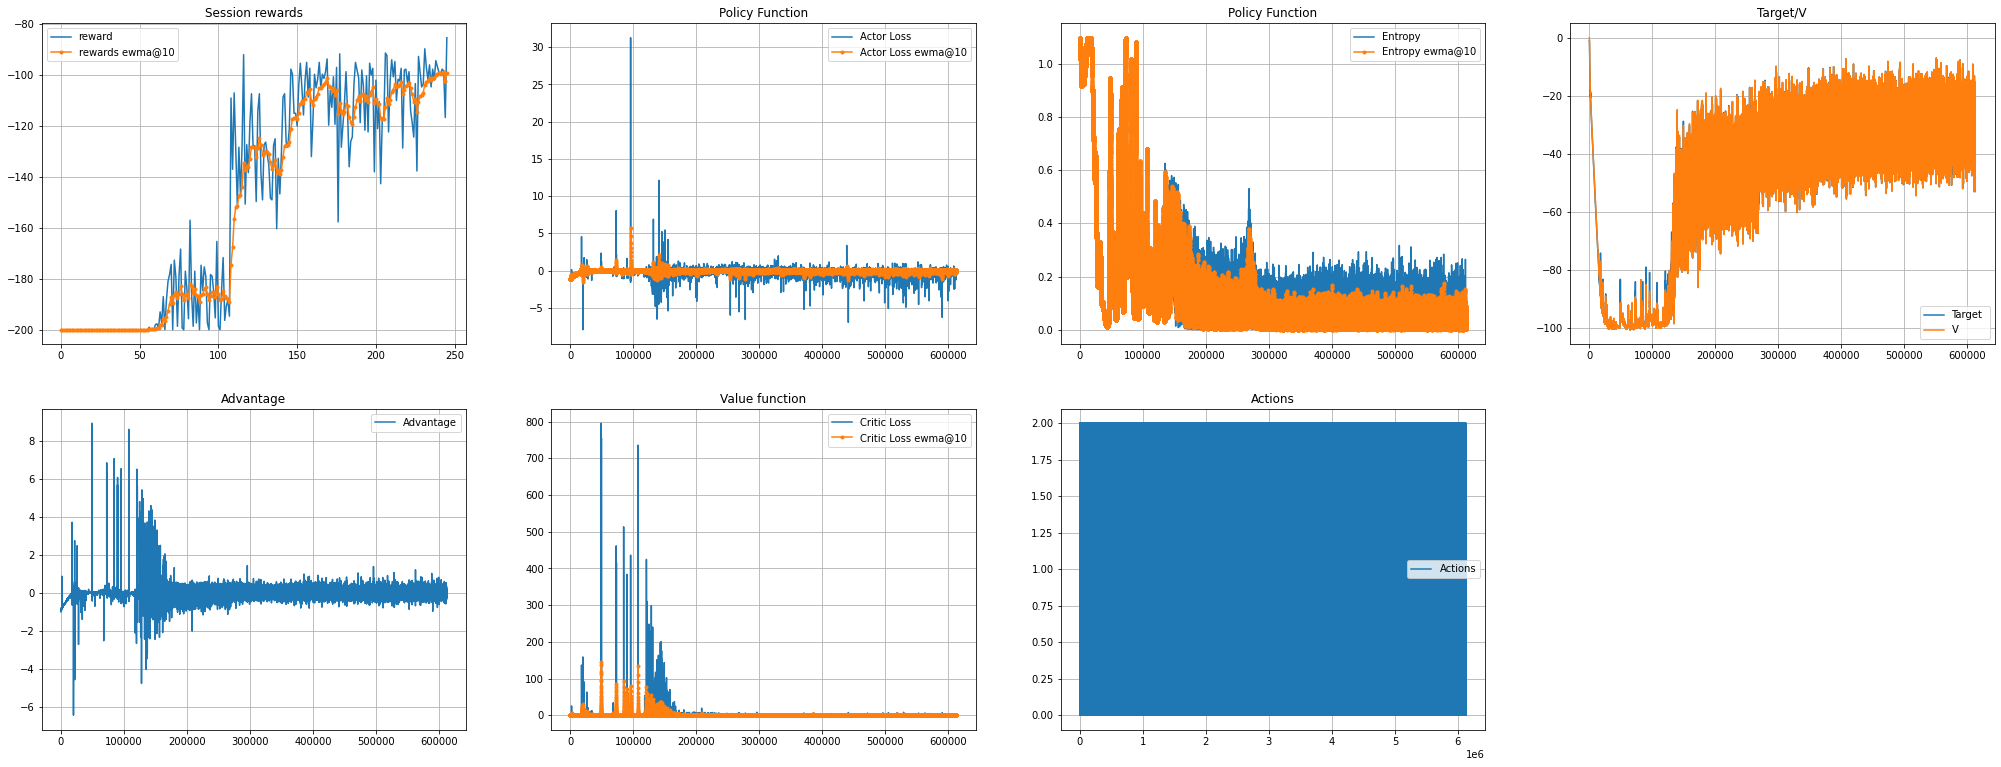

In [ ]:
mountainA3C.plots()

In [ ]:
display = Display(visible=0, size=(400, 300))
display.start()

def evaluate2(agent, env, n_games=1):
  """Plays an a game from start till done, returns per-game rewards """
  game_rewards = []
  for _ in range(n_games):
      state = env.reset()

      total_reward = 0
      while True:
          action = agent.sample_actions(agent.step([state]),0)[0]
          state, reward, done, info = env.step(action)
          total_reward += reward
          if done:
              break

      game_rewards.append(total_reward)
  return game_rewards

env_monitor = gym.wrappers.Monitor(env, directory="/content/drive/My Drive/Colab Notebooks/RL/TF_mountain_multithread/videos", force=True)
final_rewards = evaluate2(mountainA3C.agent, env_monitor, n_games=100)
env_monitor.close()

print("Final mean reward:", np.mean(final_rewards))

Final mean reward: -104.45
